In [ ]:
!pip install transformers datasets pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()

In [ ]:
import pandas as pd

# 데이터 로드 (예시)
file_path = '/content/cleaned_tweet_emotions_subset.csv'  # 코랩 환경에 맞게 경로 수정
df = pd.read_csv(file_path)

# 결측값 제거
df = df.dropna(subset=["cleaned_content"])  # NaN 제거

# 중복 데이터 제거
df = df.drop_duplicates(subset=["cleaned_content"])  # 중복된 텍스트 제거

# 텍스트 정제: 모든 텍스트를 소문자로 변환
df["cleaned_content"] = df["cleaned_content"].str.lower()

# 텍스트 정제: 특수문자 제거
import re
df["cleaned_content"] = df["cleaned_content"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x))

# 데이터 확인
print(df.head())
print(df.info())

                                     cleaned_content   sentiment
0  i know  i was listenin to bad habit earlier an...       empty
1  layin n bed with a headache  ughhhhwaitin on y...     sadness
2                      funeral ceremonygloomy friday     sadness
3                wants to hang out with friends soon  enthusiasm
4  we want to trade with someone who has houston ...     neutral
<class 'pandas.core.frame.DataFrame'>
Index: 39013 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cleaned_content  39013 non-null  object
 1   sentiment        39013 non-null  object
dtypes: object(2)
memory usage: 914.4+ KB
None


In [ ]:
#-------------------------------------------------------
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩(BERT는 숫자 입력을 사용하므로 감정 라벨(sentiment)을 숫자로 변환해야 합니다.)
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment"])  # sentiment 컬럼을 숫자로 변환
print(label_encoder.classes_)  # 라벨 순서 확인

#라벨 숫자 추가되었는지 확인..
print(df.head())
#-------------------------------------------------------------

['anger' 'boredom' 'empty' 'enthusiasm' 'fun' 'happiness' 'hate' 'love'
 'neutral' 'relief' 'sadness' 'surprise' 'worry']
                                     cleaned_content   sentiment  label
0  i know  i was listenin to bad habit earlier an...       empty      2
1  layin n bed with a headache  ughhhhwaitin on y...     sadness     10
2                      funeral ceremonygloomy friday     sadness     10
3                wants to hang out with friends soon  enthusiasm      3
4  we want to trade with someone who has houston ...     neutral      8


클래스 분포:
label
12    8330
8     8308
10    5101
5     5068
7     3671
11    2151
4     1763
9     1499
6     1313
2      779
3      742
1      178
0      110
Name: count, dtype: int64

클래스 비율 (%):
label
12    21.351857
8     21.295466
10    13.075129
5     12.990542
7      9.409684
11     5.513547
4      4.519006
9      3.842309
6      3.365545
2      1.996770
3      1.901930
1      0.456258
0      0.281957
Name: proportion, dtype: float64


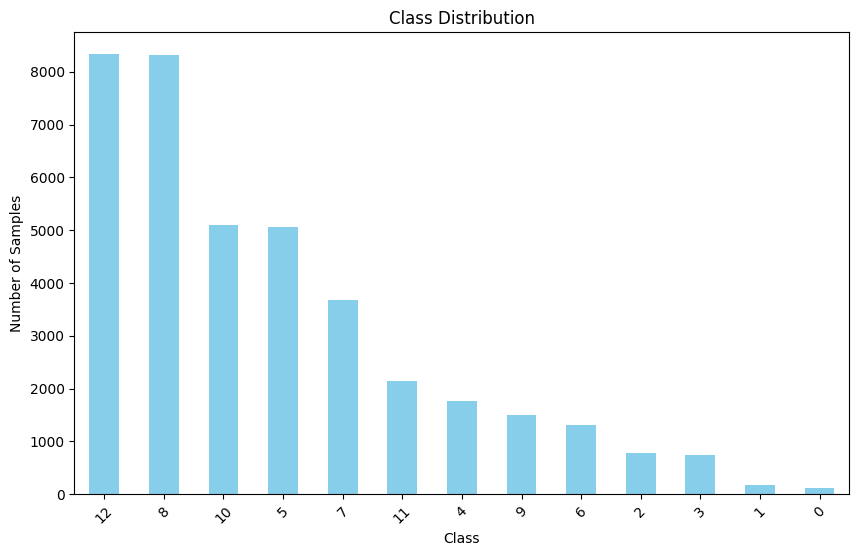

In [ ]:
# 클래스 분포 확인
class_distribution = df["label"].value_counts()

# 비율 계산
class_percentage = df["label"].value_counts(normalize=True) * 100

# 분포 출력
print("클래스 분포:")
print(class_distribution)
print("\n클래스 비율 (%):")
print(class_percentage)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.utils import resample
import pandas as pd


# 각 클래스의 목표 데이터 수
TARGET_SIZE = 3000

# 클래스 균형 조정 함수
def balance_classes(df, label_col):
    balanced_df = pd.DataFrame()
    for label, group in df.groupby(label_col):
        if len(group) > TARGET_SIZE:
            # 데이터가 많으면 언더샘플링
            sampled = group.sample(n=TARGET_SIZE, random_state=42)
        else:
            # 데이터가 적으면 오버샘플링
            sampled = resample(
                group,
                replace=True,  # 복제 허용
                n_samples=TARGET_SIZE,
                random_state=42
            )
        balanced_df = pd.concat([balanced_df, sampled])
    return balanced_df.sample(frac=1).reset_index(drop=True)


# 실행
df = balance_classes(df, label_col="label")

# 결과 확인
print(df["label"].value_counts())

label
4     3000
1     3000
0     3000
12    3000
11    3000
9     3000
2     3000
5     3000
8     3000
6     3000
10    3000
3     3000
7     3000
Name: count, dtype: int64


클래스 분포:
label
4     3000
1     3000
0     3000
12    3000
11    3000
9     3000
2     3000
5     3000
8     3000
6     3000
10    3000
3     3000
7     3000
Name: count, dtype: int64

클래스 비율 (%):
label
4     7.692308
1     7.692308
0     7.692308
12    7.692308
11    7.692308
9     7.692308
2     7.692308
5     7.692308
8     7.692308
6     7.692308
10    7.692308
3     7.692308
7     7.692308
Name: proportion, dtype: float64


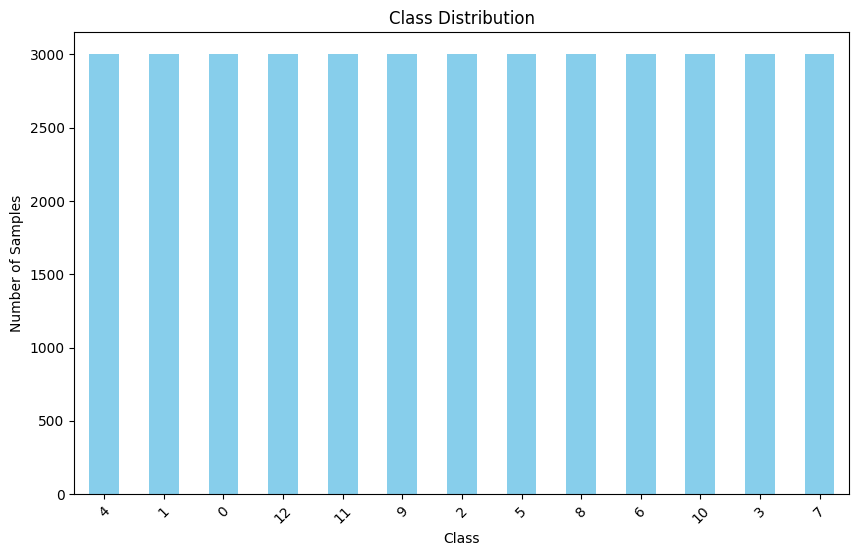

In [ ]:
# 클래스 분포 확인
class_distribution = df["label"].value_counts()

# 비율 계산
class_percentage = df["label"].value_counts(normalize=True) * 100

# 분포 출력
print("클래스 분포:")
print(class_distribution)
print("\n클래스 비율 (%):")
print(class_percentage)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 균형화 함수 (예시)
df = balance_classes(df, label_col="label")  # 기존 df를 균형화된 데이터로 덮어쓰기

# 데이터 정제
df = df[df["cleaned_content"].apply(lambda x: isinstance(x, str))]  # 문자열만 남기기

# 라벨 인코딩
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment"])  # sentiment -> 정수로 변환

# 학습 데이터와 검증 데이터 분리
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["cleaned_content"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 토크나이징 함수 정의
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )

# 학습 데이터와 검증 데이터 토크나이징
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# 결과 출력 확인
print("Train Encodings:", train_encodings)
print("Validation Encodings:", val_encodings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Train Encodings: {'input_ids': tensor([[  101,  2054,  2055,  ...,     0,     0,     0],
        [  101, 10973, 14720,  ...,     0,     0,     0],
        [  101,  1045,  2342,  ...,     0,     0,     0],
        ...,
        [  101,  9805,  2213,  ...,     0,     0,     0],
        [  101,  2061,  6517,  ...,     0,     0,     0],
        [  101,  2204, 16373,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
Validation Encodings: {'input_ids': tensor([[  101,  2145,  2031,  ...,     0,     0,     0],
        [  101, 15068,  2818,  ...,   

In [ ]:
#---------------------------------(확인 절차)----------------------------------------
# 각 문장의 길이 계산 -> max_length 설정에 영향을 줌. -> 어린이 동화 정도면 사실상 64토큰(30~40 단어 정도로 충분함.) -> pad를 줄이자.
text_lengths = [len(tokenizer(text)["input_ids"]) for text in df["cleaned_content"]]

print("최대 길이:", max(text_lengths))
print("평균 길이:", sum(text_lengths) / len(text_lengths))
print("최소 길이:", min(text_lengths))

최대 길이: 51
평균 길이: 16.80051282051282
최소 길이: 3


In [ ]:
len(train_texts), len(train_labels), len(val_texts), len(val_labels)

(31200, 31200, 7800, 7800)

In [ ]:
print(train_encodings["input_ids"].shape)
print(val_encodings["input_ids"].shape)


torch.Size([31200, 64])
torch.Size([7800, 64])


In [ ]:
print(train_texts[0])  # 원본 텍스트
print(tokenizer.decode(train_encodings["input_ids"][0]))  # 디코딩된 텍스트
#-----------------------------------------------------------------------------------------

what about me
[CLS] what about me [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
# 데이터셋 생성
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

In [ ]:
#-------------------------------------------------------------------
from collections import Counter

# Train과 Validation 데이터 분포 출력
print("Train label distribution:", Counter(train_labels))
print("Validation label distribution:", Counter(val_labels))

Train label distribution: Counter({12: 2418, 1: 2415, 5: 2412, 7: 2411, 0: 2404, 2: 2402, 8: 2399, 3: 2397, 4: 2395, 9: 2394, 6: 2387, 11: 2386, 10: 2380})
Validation label distribution: Counter({10: 620, 11: 614, 6: 613, 9: 606, 4: 605, 3: 603, 8: 601, 2: 598, 0: 596, 7: 589, 5: 588, 1: 585, 12: 582})


In [ ]:
print(train_encodings.keys())  # 'input_ids', 'attention_mask' 등이 있는지 확인
print(train_labels[:10])  # 라벨 값의 분포 확인
print(val_labels[:10])  # 검증 데이터 라벨 분포 확인

sample_item = train_dataset[0]
print(sample_item)  # 'input_ids', 'attention_mask', 'labels' 확인

print(len(train_dataset))  # train_labels와 길이가 동일해야 함
print(len(val_dataset))  # val_labels와 길이가 동일해야 함

from collections import Counter

for i in range(5):
    print(train_dataset[i])  # 각 샘플의 input_ids와 label 확인

#-----------------------------------------------------------------

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[8, 4, 7, 11, 4, 6, 3, 12, 11, 2]
[12, 12, 5, 0, 4, 7, 9, 3, 4, 11]
{'input_ids': tensor([ 101, 2054, 2055, 2033,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Distil BERT 모델 로드 (감정 라벨 개수에 맞게 num_labels 수정)
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # 에포크마다 평가
    save_strategy="epoch",        # 에포크마다 저장
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # 배치 크기 16
    num_train_epochs=10,            # 10 에포크
    load_best_model_at_end=True,    # 최고의 모델 저장
    save_total_limit=2,             # 체크포인트 제한
    logging_dir="./logs",
    report_to="wandb",  # W&B 활성화
)

#기본적으로 Hugging Face의 trainer는 train은 shuffle = True이고, val은 shuffle = False이다.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerN

In [ ]:
#-----------------------------------------------------
print(f"Number of labels: {num_labels}")

Number of labels: 13


In [ ]:
print(len(train_dataset))  # 학습 데이터 크기 확인
print(len(val_dataset))    # 검증 데이터 크기 확인
#-------------------------------------------------------

31200
7800


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,2.559000,2.187232
2,1.846400,1.739981
3,1.525100,1.498219
4,1.235900,1.363308
5,1.009500,1.238633
6,0.815100,1.112602
7,0.696300,1.069034
8,0.577300,1.079038
9,0.483500,1.008505
10,0.419800,1.015098


TrainOutput(global_step=19500, training_loss=1.1332690930488782, metrics={'train_runtime': 4464.1207, 'train_samples_per_second': 69.891, 'train_steps_per_second': 4.368, 'total_flos': 1.0262344614912e+16, 'train_loss': 1.1332690930488782, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.9387367367744446,
 'eval_runtime': 30.9076,
 'eval_samples_per_second': 252.365,
 'eval_steps_per_second': 31.546,
 'epoch': 10.0}

In [ ]:
# 모델 저장 경로를 지정
save_directory = '/content/saved_model'

# 모델 저장
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("모델이 저장되었습니다:", save_directory)

모델이 저장되었습니다: /content/saved_model


In [ ]:
import shutil

# 모델 폴더를 압축
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')

print("압축 완료: /content/saved_model.zip")

압축 완료: /content/saved_model.zip


In [ ]:
from google.colab import files

# 압축된 파일 다운로드
files.download('/content/saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#위의 저장은 새로 만든거고 지금은 지운 test나 새로운 문장을 분석하는게 모델에 영향을 주게 한거 같다. 사실 코드에서 그냥 model 학습한걸 무시하고 새로운 모델을 가져와서 문장 하나만 모델로 학습한걸로 취급해서 model이
# 이상한거로 바뀐 느낌? 지금은 자고 일어나서 train을 아예 다시 돌려서(근데 일단 gpt한테 train 이후에 모델이 안바뀌는 코드도 물어보고) 하면서 할듯?
from transformers import AutoModelForSequenceClassification, AutoTokenizer

loaded_model = AutoModelForSequenceClassification.from_pretrained('./saved_model')
loaded_tokenizer = AutoTokenizer.from_pretrained('./saved_model')

# 모델 사용
test_text = "happiness"
inputs = loaded_tokenizer(test_text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 디바이스로 이동
loaded_model.to(device)

# 입력 데이터를 디바이스로 이동
inputs = {key: val.to(device) for key, val in inputs.items()}

# 모델 평가 모드 설정
loaded_model.eval()

# 예측 실행
with torch.no_grad():
    outputs = loaded_model(**inputs)
    logits = outputs.logits

print("Logits:", logits)
# 모델의 예측 결과 (숫자 레이블)
predicted_label = torch.argmax(logits, dim=-1).cpu().item()

# 라벨 인코더에서 감정 매핑 가져오기
label_map = {index: label for index, label in enumerate(label_encoder.classes_)}
print(label_map)  # {0: 'anger', 1: 'boredom', 2: 'empty', ...}

# 숫자 레이블 -> 감정 라벨 변환
predicted_sentiment = label_map[predicted_label]

print(f"Predicted Sentiment: {predicted_sentiment}")

Logits: tensor([[-0.3282,  0.0050, -0.0833, -0.2257,  0.3599,  0.0170, -0.2935,  0.1689,
          0.0731, -0.4823,  0.1753,  0.3551, -0.1400]], device='cuda:0')
{0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fun', 5: 'happiness', 6: 'hate', 7: 'love', 8: 'neutral', 9: 'relief', 10: 'sadness', 11: 'surprise', 12: 'worry'}
Predicted Sentiment: fun


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# 테스트 데이터 준비
test_encodings = tokenizer(
    val_texts,
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt"
)
test_labels = torch.tensor(val_labels)  # 레이블을 텐서로 변환

# TensorDataset 생성
test_dataset = TensorDataset(
    test_encodings["input_ids"],
    test_encodings["attention_mask"],
    test_labels
)

# DataLoader 생성
test_dataloader = DataLoader(test_dataset, batch_size=16)

# 모델 평가
model.eval()  # 평가 모드로 전환
predictions, true_labels = [], []

# 배치별로 예측 수행
for batch in test_dataloader:
    input_ids, attention_mask, labels = [b.to(model.device) for b in batch]

    # 모델 예측
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits

    # 예측값 및 실제값 저장
    batch_predictions = torch.argmax(logits, axis=-1).cpu().tolist()
    batch_labels = labels.cpu().tolist()
    predictions.extend(batch_predictions)
    true_labels.extend(batch_labels)

# 정확도 계산
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.08


In [ ]:
# 틀린 결과 확인
wrong_predictions = []

for i in range(len(val_texts)):
    if predictions[i] != true_labels[i]:  # 예측값과 실제 라벨이 다른 경우
        wrong_predictions.append({
            "Text": val_texts[i],  # 입력 텍스트
            "True Label": label_encoder.inverse_transform([true_labels[i]])[0],  # 실제 라벨
            "Predicted Label": label_encoder.inverse_transform([predictions[i]])[0]  # 예측 라벨
        })

# 틀린 결과 출력
print(f"Total Wrong Predictions: {len(wrong_predictions)}")
for idx, wrong in enumerate(wrong_predictions[:10]):  # 상위 10개만 출력
    print(f"{idx + 1}:")
    print(f"Text: {wrong['Text']}")
    print(f"True Label: {wrong['True Label']}")
    print(f"Predicted Label: {wrong['Predicted Label']}")
    print("---")

Total Wrong Predictions: 7196
1:
Text: hah eeee although understandable i need a new picture for this thing but im all sweaty
True Label: sadness
Predicted Label: fun
---
2:
Text: add me up and lets play something
True Label: happiness
Predicted Label: fun
---
3:
Text: it looks like the office tv does get mlb network and it looks like mlbn will not be televising the detbal game today  wieters
True Label: sadness
Predicted Label: fun
---
4:
Text: not but i went to his page and it made me hungry
True Label: surprise
Predicted Label: fun
---
5:
Text: cleaned out me followers list and blocked the porn girls amp crap now i look like a spammer
True Label: hate
Predicted Label: fun
---
6:
Text: is still sick but still loves revenge and the possibility of more revenge to come
True Label: love
Predicted Label: fun
---
7:
Text: being today and all were gonna use the force to make it happen
True Label: enthusiasm
Predicted Label: fun
---
8:
Text: we want to trade with someone who has houston tick

In [ ]:
from collections import Counter

# 데이터셋 클래스 분포 확인
print(Counter(val_labels))

Counter({8: 630, 11: 628, 0: 623, 10: 612, 1: 606, 4: 605, 2: 599, 7: 595, 6: 594, 3: 588, 5: 579, 9: 571, 12: 570})
